# Spatial Filtering with Python
by Brandon Janes

In [2]:
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
%matplotlib inline

## Section 1: Basic Map Algebra
#### How the footprint works

![Image of how a spatial filter footprint (or window) calculates the mean of surrounding values to replace a null value.](images/nan_control.jpg)

In [11]:
c = np.random.randint(0, 10, 9)
indata_ = np.reshape(c, (3,3))
# write a null in the middle
window = np.where(indata_==8, np.nan, indata_) 
window

array([[ 2.,  7.,  2.],
       [ 4., nan,  1.],
       [ 3.,  0.,  3.]])

Replace ```nan```(null) values with the mean from the array

In [13]:
# The middle value is calculated based on 
# its surrounding neighbors in the input dataset 
np.where(np.isnan(window),
         np.nanmean(window),window)

array([[2.  , 7.  , 2.  ],
       [4.  , 2.75, 1.  ],
       [3.  , 0.  , 3.  ]])

In [14]:
(2+7+2+4+1+3+0+1)/8 # that checks out

2.5

## A slightly bigger matrix

In [3]:
# generate random matrix w/ nulls
a = np.random.randint(0, 10, 64)
indata01 = np.reshape(a, (8,8))
data = np.where(indata01==0, np.nan, indata01) # replace all zero values with nan
data

array([[ 2.,  3.,  6., nan,  3.,  7.,  8.,  2.],
       [ 2., nan,  4.,  2.,  3.,  4., nan,  2.],
       [ 7.,  9.,  2.,  8.,  8., nan,  2.,  3.],
       [ 7.,  1.,  5.,  9.,  1.,  5.,  2.,  3.],
       [ 2.,  7.,  4.,  5.,  9.,  1.,  7.,  6.],
       [ 3.,  5.,  6.,  7.,  3.,  4., nan,  6.],
       [ 8., nan,  1.,  7.,  6.,  3.,  3., nan],
       [ 2.,  7.,  5.,  7., nan,  6.,  4.,  6.]])

In [4]:
def conv_mapping(x):
    """
    When the fifth value (x[4]) of the filter array (the center of the window) 
    is null, replace it with the mean of the surrounding values.
    """
    if np.isnan(x[4]) and not np.isnan(np.delete(x, 4)).all():
        return np.nanmean(np.delete(x, 4))
    else:
        return x[4]

![Graphical demonstration for how a convolutional filter travels pixel by pixel across a raster matrix.](images/convolution.jpg)

In [5]:
mask = np.ones((3, 3))
result = ndimage.generic_filter(data, function=conv_mapping, footprint=mask, mode='wrap')#, cval=np.NaN)
np.set_printoptions(precision=3)
print(result)

[[2.    3.    6.    4.286 3.    7.    8.    2.   ]
 [2.    4.375 4.    2.    3.    4.    4.    2.   ]
 [7.    9.    2.    8.    8.    3.571 2.    3.   ]
 [7.    1.    5.    9.    1.    5.    2.    3.   ]
 [2.    7.    4.    5.    9.    1.    7.    6.   ]
 [3.    5.    6.    7.    3.    4.    4.286 6.   ]
 [8.    4.625 1.    7.    6.    3.    3.    4.571]
 [2.    7.    5.    7.    5.571 6.    4.    6.   ]]


## Apply filter to "real-world" raster data matrix
Using this technique we can apply our "filter footprint" to a "raster" matrix to eliminate ```nan``` values.

### upload dataset 

In [6]:
df = pd.read_csv("data/data.csv")
df.shape, df.isna().sum() # how many nulls per column?

((220739, 4),
 Unnamed: 0      0
 x               0
 y               0
 elevation     100
 dtype: int64)

* note: I have added the null values randomly but synthetically

## Transform data: from tall (stacked) to matrix (grid) form

In [7]:
def make_grid(df,resolution):
    """
    # Define interpolation inputs and
    # convert everything to NumPy arrays for optimization
    """
    points = np.array(list(zip(df.x,df.y)))
    values = np.array(df.elevation.values)
    x_values = np.array(df.x)
    y_values = np.array(df.y)
    xRange = np.arange(x_values.min(),x_values.max() + resolution, resolution)
    yRange = np.arange(y_values.min(),y_values.max() + resolution, resolution)
    gridX,gridY = np.meshgrid(xRange, yRange)
    gridPh = griddata(points, values, (gridX,gridY), method='nearest')
    return gridPh

In [8]:
grid = make_grid(df, 8)

Text(0.5, 1.0, 'Elevation (before)')

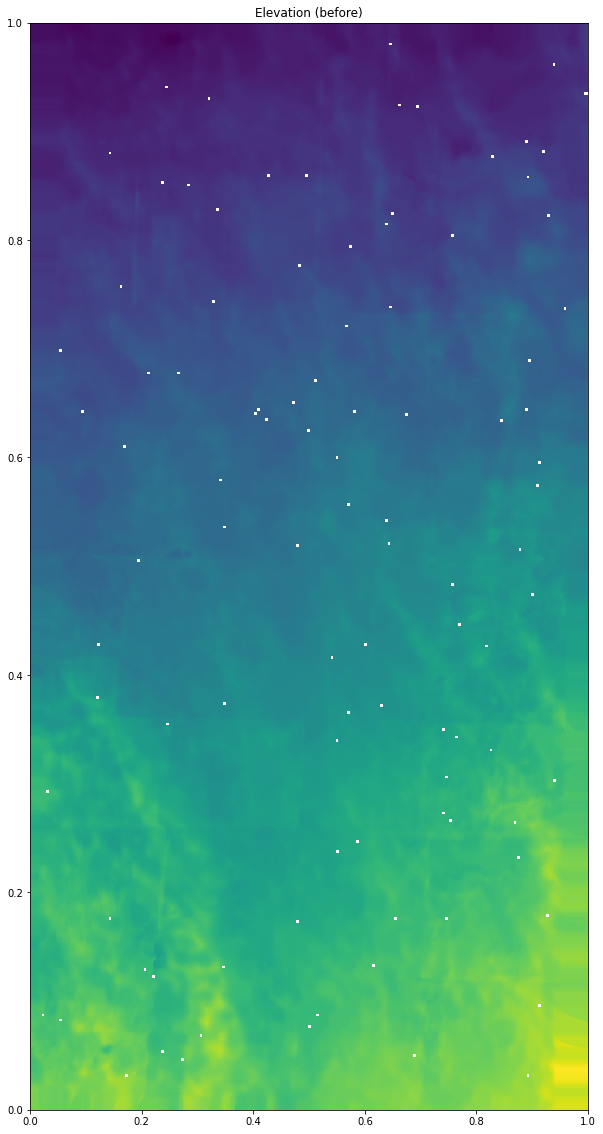

In [9]:
# BEFORE
fig, ax = plt.subplots(figsize=(10, 20))
plt.imshow(grid.T, extent=(0,1,0,1), origin='lower',aspect='auto')
plt.title('Elevation (before)')

As we can see, missing pixels can be found. Time to smooth them out.

In [10]:
print("How many null values: ", len(np.argwhere(np.isnan(grid))))

How many null values:  368


In [11]:
np.argwhere(np.isnan(grid))[:5]

array([[ 15, 110],
       [ 15, 111],
       [ 20, 371],
       [ 20, 372],
       [ 21, 371]])

In [12]:
grid[15,110] # Let's see if this one changes after filtering

nan

## Apply spatial filtering to eliminate null values 

In [13]:
grid_smooth = ndimage.generic_filter(grid,
                function=conv_mapping,
                footprint=np.ones((3, 3)), mode='constant', cval=np.NaN)
print("How many null values: ", len(np.argwhere(np.isnan(grid_smooth))))

How many null values:  0


In [14]:
grid_smooth[15,110] # previously null

261.78285714285715

This value (above) that was once ```nan``` is now the mean of the surrounding eight cells.

Text(0.5, 1.0, 'Elevation in meters (after smoothing)')

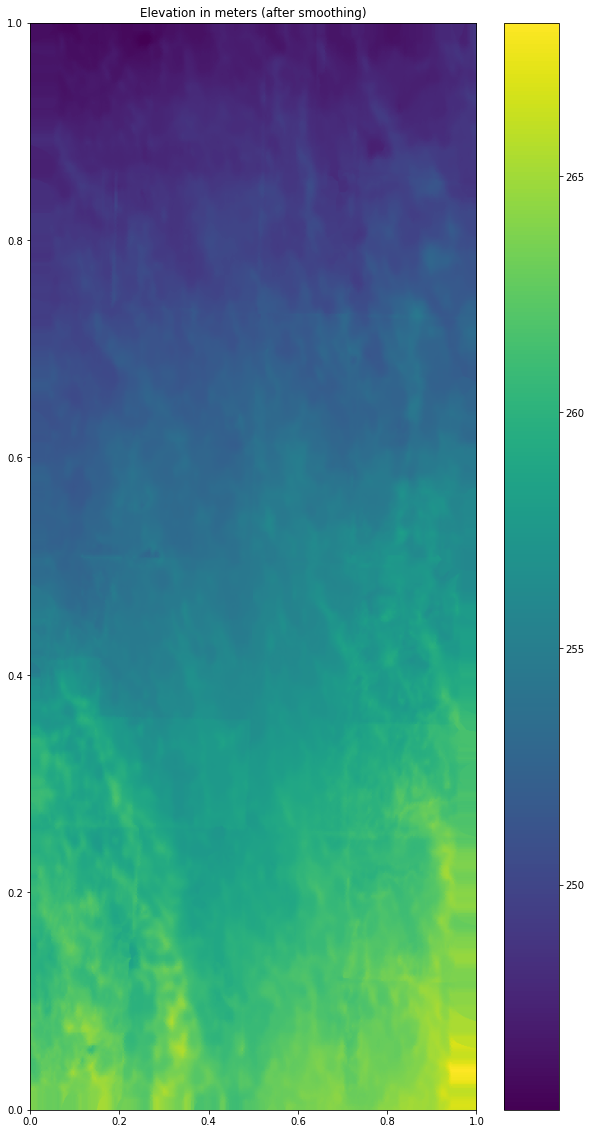

In [15]:
# AFTER
fig, ax = plt.subplots(figsize=(10, 20))
plt.imshow(grid_smooth.T, extent=(0,1,0,1), origin='lower',aspect='auto')
plt.colorbar()
plt.title('Elevation in meters (after smoothing)')

No holes!!!!

## Advanced algorithms: slope
* cell width 15 meters
* cell height -15 meters

### The Neighborhood Algorithm

![The Neighborhood Algorithm](images/neighborhood.jpeg)

In [16]:
def slope(x):
    north_south = ((x[6]+(2*x[7])+x[8])-(x[0]+(x[1])+x[2]))/ (8*-15)
    east_west = ((x[2]+(2*x[5])+x[8])-(x[0]+(x[1])+x[2]))/ (8*15)
    dist = np.sqrt(np.square(north_south) + np.square(east_west))
    return np.arctan(dist) * 180/np.pi # convert to degrees

In [17]:
slope_dem = ndimage.generic_filter(grid_smooth,
                   function=slope,
                   footprint=np.ones((3, 3)), mode='mirror')

Text(0.5, 1.0, 'Slope')

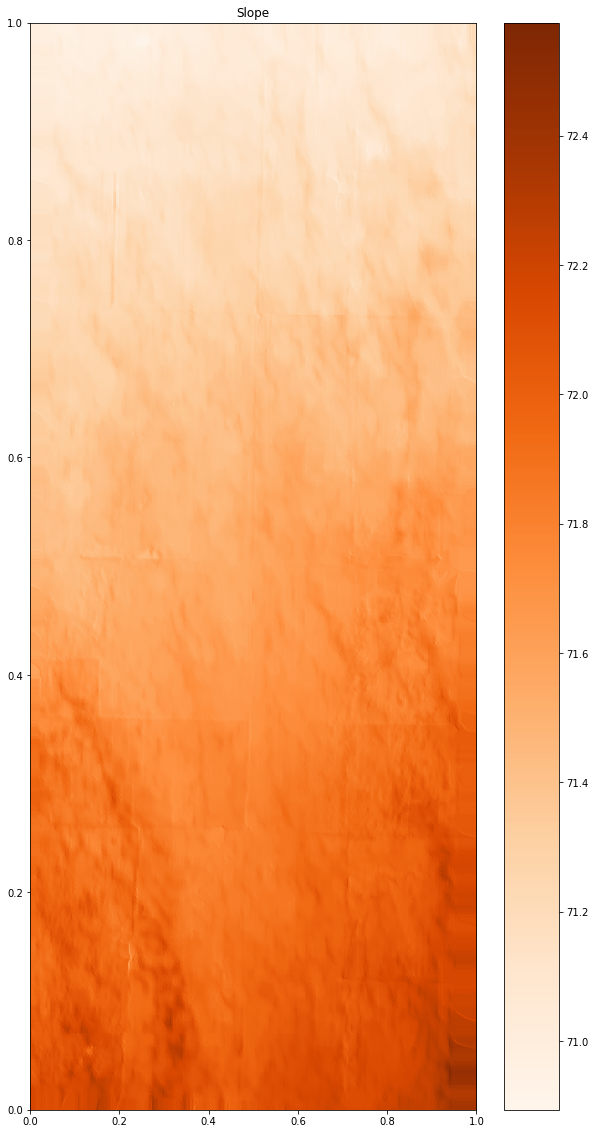

In [18]:
fig, ax = plt.subplots(figsize=(10, 20))
plt.imshow(slope_dem.T, extent=(0,1,0,1), cmap='Oranges', origin='lower',aspect='auto')
plt.colorbar()
plt.title('Slope')

This dataset is farmland, so the slope graph is pretty boring... but you get the idea.